线性模型+特征工程+XGB拟合残差

In [1]:

! pip install hyperopt

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # more plots
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge,Lasso
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
# 忽略warnings
import warnings
warnings.filterwarnings("ignore")

模版函数

In [3]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    计算平均绝对百分比误差(MAPE)
    
    参数:
        y_true: 真实值数组，包含实际观测到的目标变量值
        y_pred: 预测值数组，包含模型预测的目标变量值
        
    返回:
        float: 平均绝对百分比误差，以百分比形式表示
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False, subtitle=""):
    """
    绘制模型预测结果与实际值的对比图，可选展示预测区间和异常值
    
    参数:
        model: 已训练的预测模型
        X_train: 训练数据集的特征
        X_test: 测试数据集的特征
        y_train: 训练数据集的目标变量
        y_test: 测试数据集的目标变量
        plot_intervals: 布尔值，是否绘制预测区间
        plot_anomalies: 布尔值，是否标记异常值（需与plot_intervals同时为True）
        subtitle: 图表的副标题
    """
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.index, y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        # 使用时间序列交叉验证计算误差范围
        tscv = TimeSeriesSplit(n_splits=3)
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)  # 平均绝对误差
        deviation = cv.std()    # 误差标准差

        # 计算95%置信区间（1.96是95%置信区间的z值）
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(y_test.index, lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(y_test.index, upper, "r--", alpha=0.5)

        if plot_anomalies:
            # 标记超出预测区间的异常值
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(y_test.index, anomalies, "o", markersize=10, label="Anomalies")

    # 计算并展示MAPE
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title((subtitle + "Mean absolute percentage error {0:.2f}%").format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def plotModelBoostingResults(model1, model2, X_test, y_test):
    """
    绘制两个模型集成（加权求和）的预测结果与实际值的对比图
    
    参数:
        model1: 第一个已训练的预测模型
        model2: 第二个已训练的预测模型
        X_test: 测试数据集的特征
        y_test: 测试数据集的目标变量
    """
    prediction1 = model1.predict(X_test)
    prediction2 = model2.predict(X_test)
    prediction = prediction1 + prediction2  # 简单相加集成两个模型的预测结果

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.index, y_test.values, label="actual", linewidth=2.0)

    # 计算并展示MAPE
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def plotCoefficients(model):
    """
    绘制模型特征系数的条形图，按系数绝对值排序
    
    参数:
        model: 具有coef_属性的线性模型（如线性回归、逻辑回归等）
    """
    # 注意：这里使用了全局变量X_train，实际应用中建议作为参数传入
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    # 按系数绝对值降序排序
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    # 绘制y=0参考线
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


def code_mean(data, cat_feature, real_feature):
    """
    计算分类特征每个类别对应的数值特征的均值
    
    参数:
        data: 包含特征的DataFrame
        cat_feature: 分类特征的列名
        real_feature: 数值特征的列名
        
    返回:
        dict: 键为分类特征的唯一值，值为对应数值特征的均值
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())


def makeCirclyStats(data, target, cols, stats):
    """
    为指定列生成基于目标变量的分组统计特征
    
    参数:
        data: 包含特征的DataFrame
        target: 目标变量的列名
        cols: 用于分组的特征列表
        stats: 要计算的统计量列表（如'mean'、'median'、'std'等）
    """
    for col in cols:
        for stat in stats:
            # 生成新特征列名：原列名_统计量
            data[col + '_' + stat] = data.groupby(col)[target].transform(stat)


def featuresRank(model, X_train):
    """
    生成模型特征重要性排名（基于系数绝对值）
    
    参数:
        model: 具有coef_属性的线性模型
        X_train: 训练数据集的特征（用于获取特征名称）
        
    返回:
        DataFrame: 包含特征系数的DataFrame，按系数绝对值降序排列
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    # 按系数绝对值降序排序并删除临时列
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    return coefs


def prepareData(data):
    """
    准备训练和测试数据：处理缺失值、划分数据集、标准化特征
    
    参数:
        data: 包含特征和目标变量的原始DataFrame，需包含'y'列作为目标变量
        
    返回:
        tuple: 包含以下元素的元组
            X_train: 标准化后的训练特征
            X_test: 标准化后的测试特征
            y_train: 训练目标变量
            y_test: 测试目标变量
    """
    data_ = data.copy()
    # 移除包含缺失值的行（仅保留目标变量非空的样本）
    y = data_.dropna().y
    X = data_.dropna().drop(['y'], axis=1)
    # 按时间序列顺序划分训练集和测试集（不打乱顺序）
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
    # 标准化特征（使用训练集的均值和标准差）
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train, X_test, y_train, y_test

加入数据

In [4]:

Df = pd.read_excel('/Users/kris/Desktop/DA/ML/特征工程/时序线形模型+XGBoost/data.xlsx', index_col=0, date_parser='date')
Df = Df.dropna()
Df.columns = ["y"]
Df.head()

,y
指标名称,
2013-01-01,68.6
2013-01-02,68.2
2013-01-03,67.2
2013-01-04,69.4
2013-01-05,71.8


历史特征平移

In [5]:

data = Df['2015-01-01':].copy()
lags = range(1, 31)
for i in lags:
    data["lag_{}".format(i)] = data.y.shift(i)
data.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
指标名称,,,,,,,,,,,,,,,,,,,,,
2015-01-02,66.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,68.9,66.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,69.3,68.9,66.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,72.3,69.3,68.9,66.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,72.7,72.3,69.3,68.9,66.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


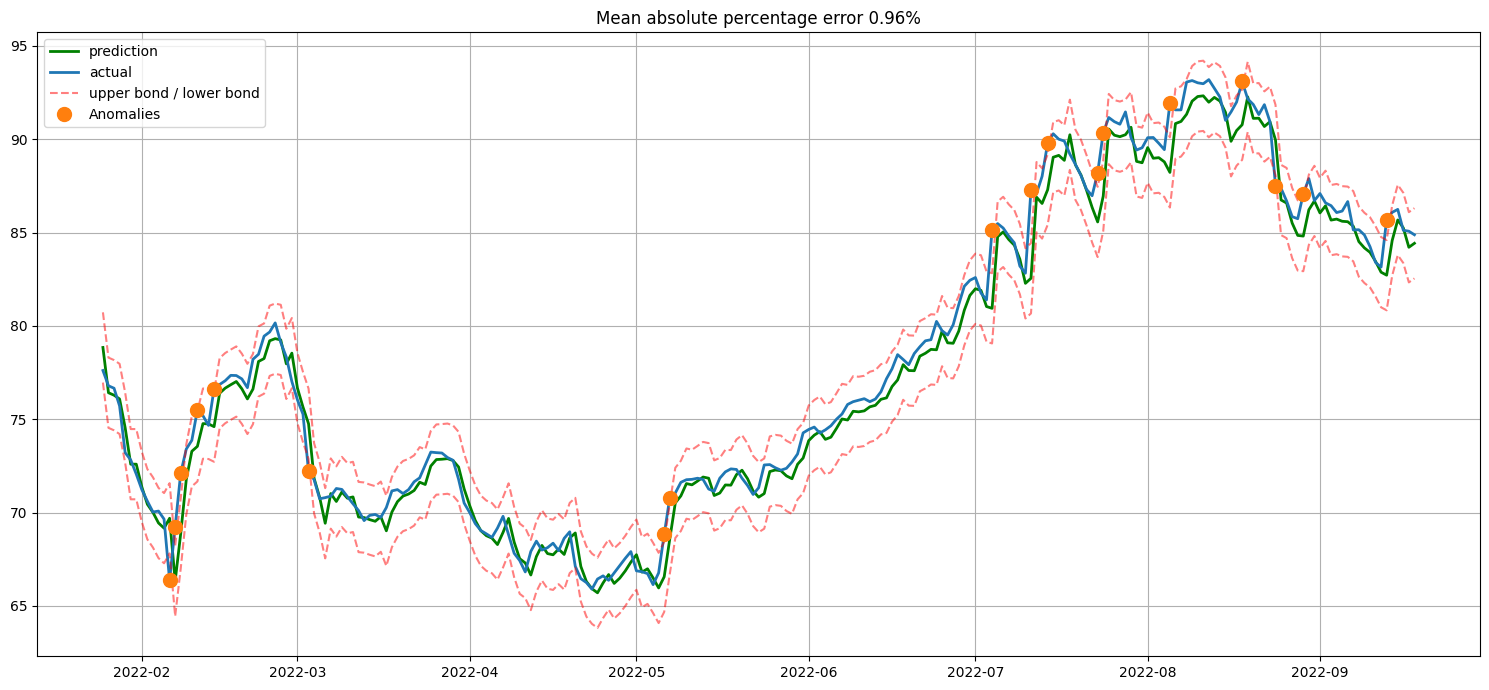

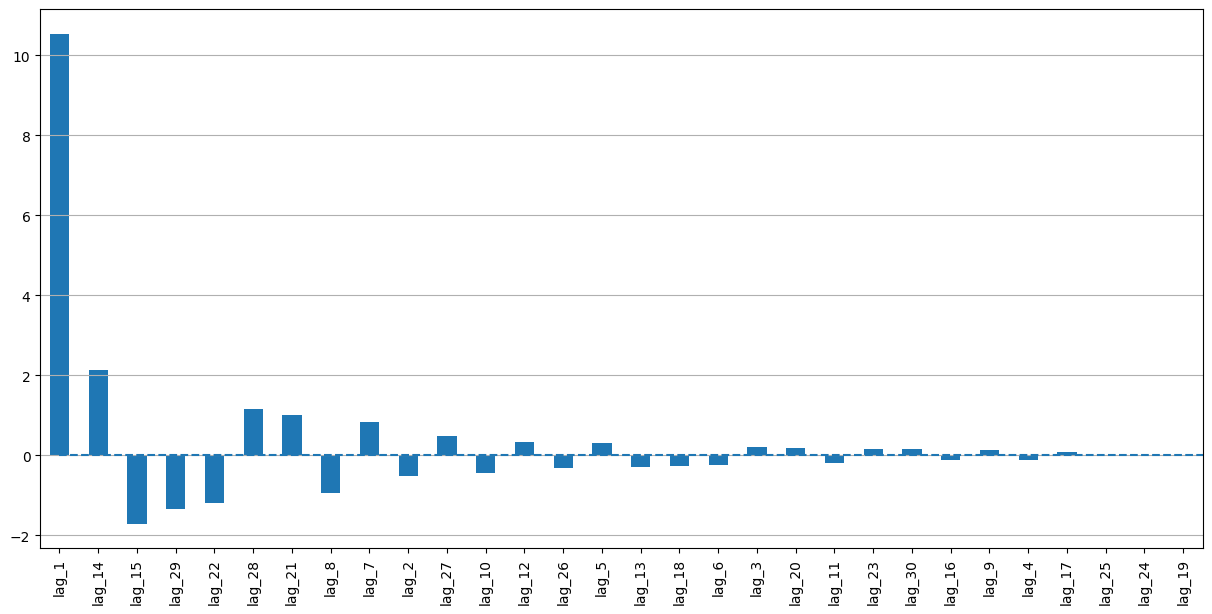

In [6]:

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

查看变量之间的相关性

<Axes: >

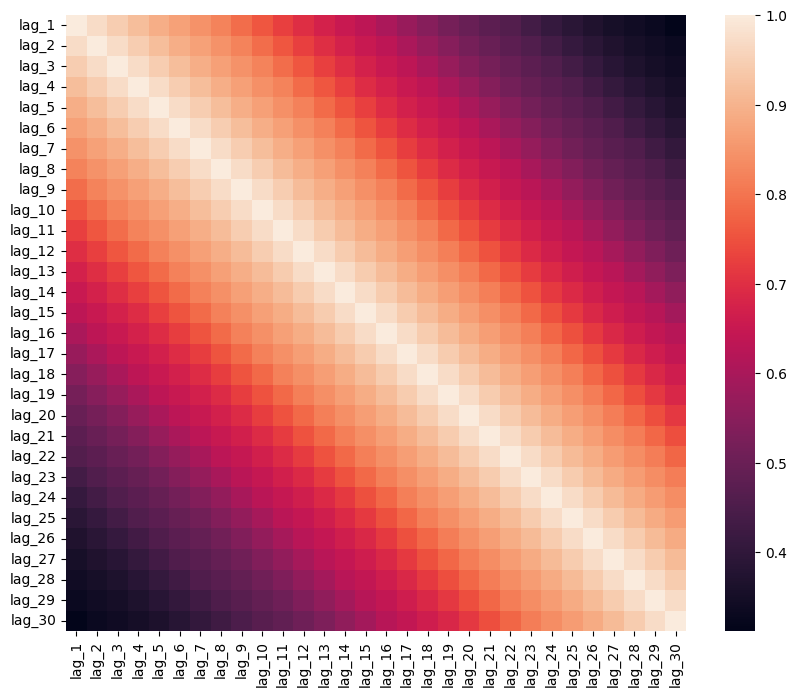

In [7]:

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr())


减少相关性、删除冗余变量

In [8]:

data = Df['2015-01-01':].copy()
lags = [1,14,21,28]
for i in lags:
    data["lag_{}".format(i)] = data.y.shift(i)
data.head()

,y,lag_1,lag_14,lag_21,lag_28
指标名称,,,,,
2015-01-02,66.7,NaN,NaN,NaN,NaN
2015-01-04,68.9,66.7,NaN,NaN,NaN
2015-01-05,69.3,68.9,NaN,NaN,NaN
2015-01-06,72.3,69.3,NaN,NaN,NaN
2015-01-07,72.7,72.3,NaN,NaN,NaN


再训练一下

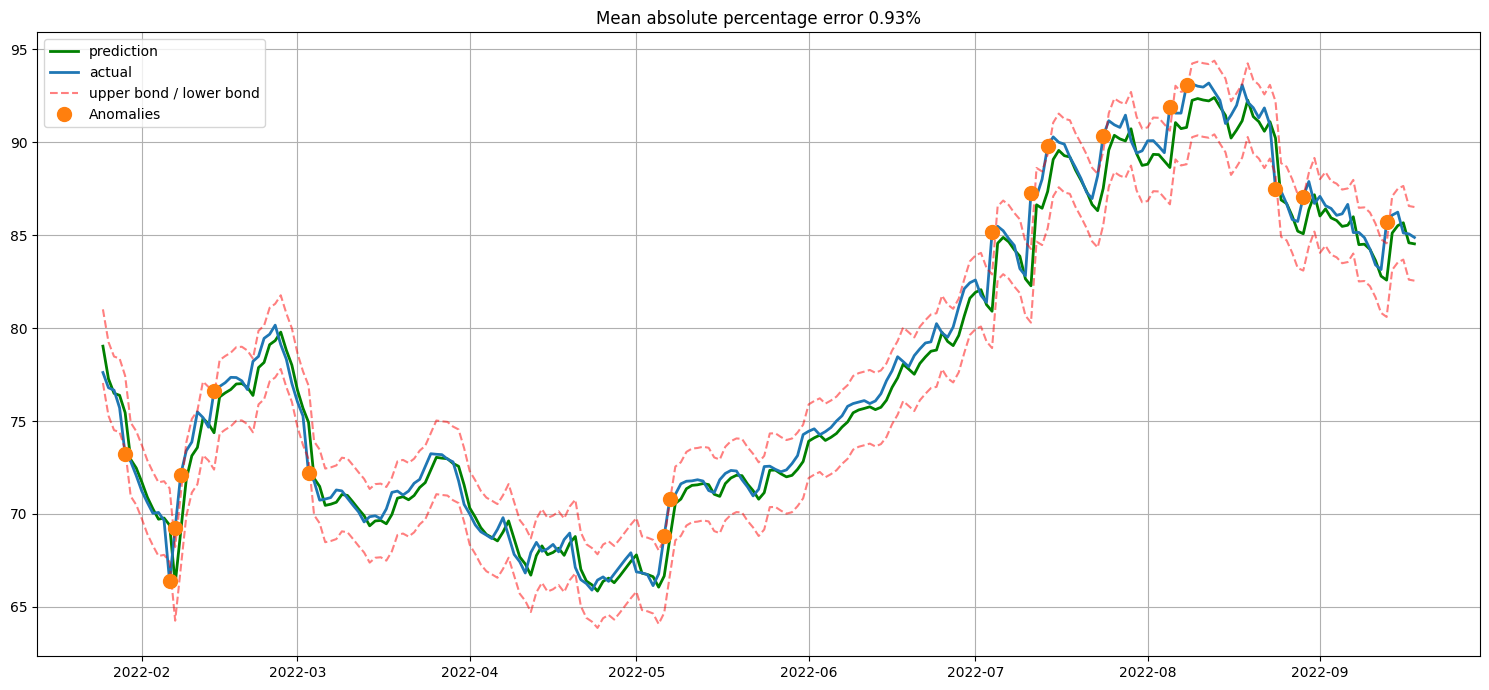

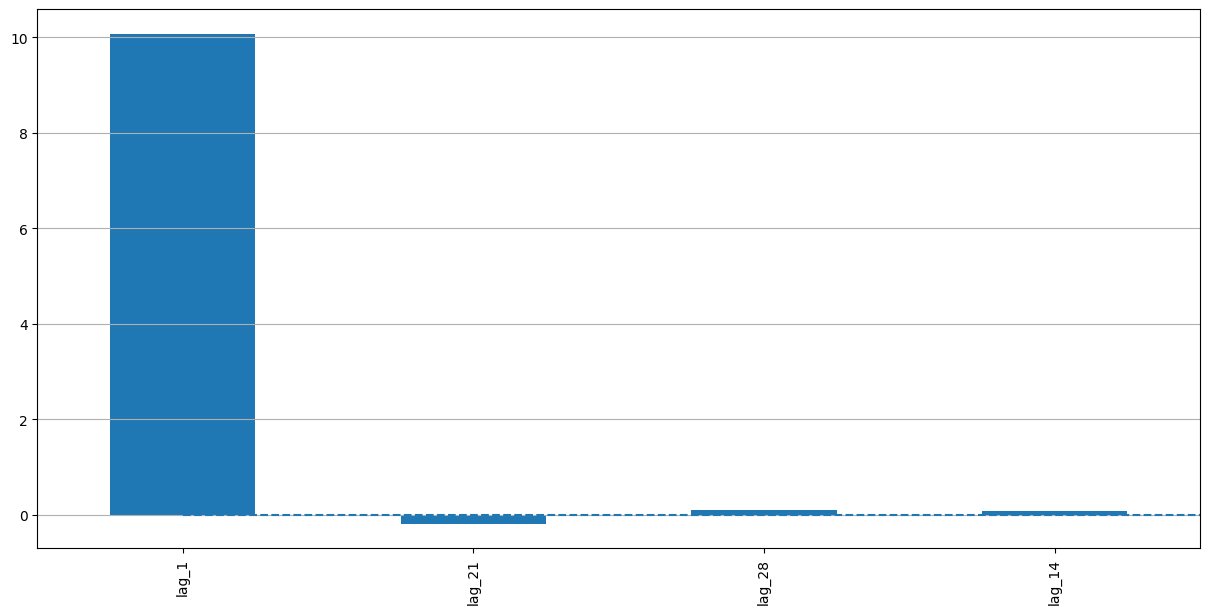

In [9]:

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)


lag_1 占的权重过高，过拟合，导致预测滞后


引入日期特征

In [10]:

data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6]) * 1
data['quarter'] = data.index.quarter
data['month'] = data.index.month
data['dayofmonth'] = data.index.day

data.head()

,y,lag_1,lag_14,lag_21,lag_28,weekday,is_weekend,quarter,month,dayofmonth
指标名称,,,,,,,,,,
2015-01-02,66.7,NaN,NaN,NaN,NaN,4,0,1,1,2
2015-01-04,68.9,66.7,NaN,NaN,NaN,6,1,1,1,4
2015-01-05,69.3,68.9,NaN,NaN,NaN,0,0,1,1,5
2015-01-06,72.3,69.3,NaN,NaN,NaN,1,0,1,1,6
2015-01-07,72.7,72.3,NaN,NaN,NaN,2,0,1,1,7


<Axes: title={'center': 'dayofmonth averages'}>

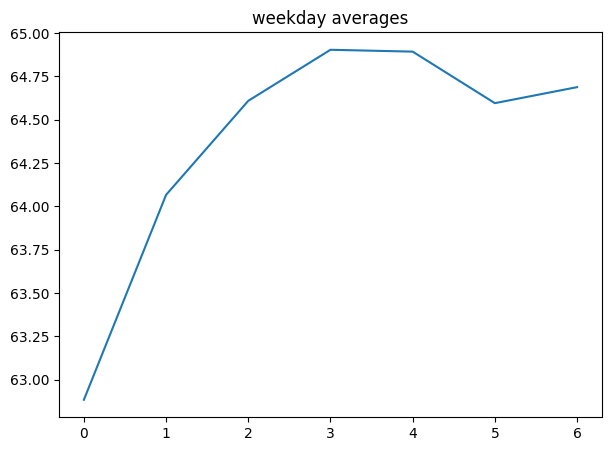

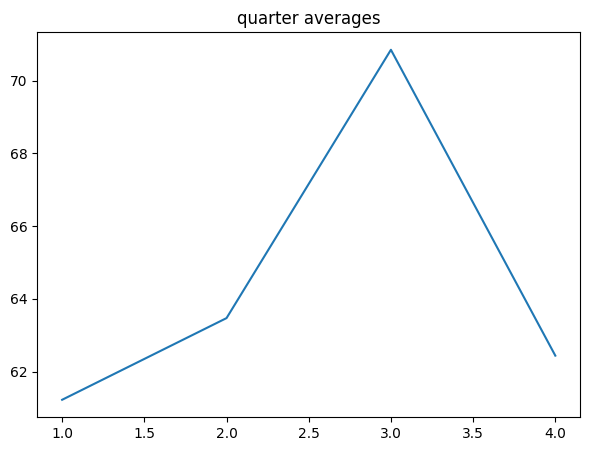

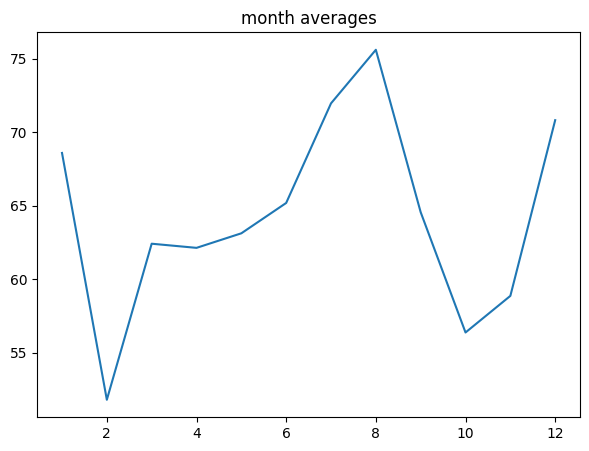

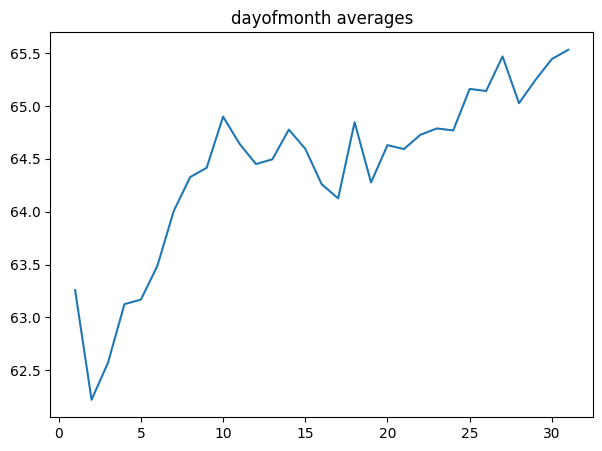

In [11]:

weekday = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("weekday averages")
pd.DataFrame.from_dict(weekday, orient='index')[0].plot()

quarter = code_mean(data, 'quarter', "y")
plt.figure(figsize=(7, 5))
plt.title("quarter averages")
pd.DataFrame.from_dict(quarter, orient='index')[0].plot()

month = code_mean(data, 'month', "y")
plt.figure(figsize=(7, 5))
plt.title("month averages")
pd.DataFrame.from_dict(month, orient='index')[0].plot()

dayofmonth = code_mean(data, 'dayofmonth', "y")
plt.figure(figsize=(7, 5))
plt.title("dayofmonth averages")
pd.DataFrame.from_dict(dayofmonth, orient='index')[0].plot()

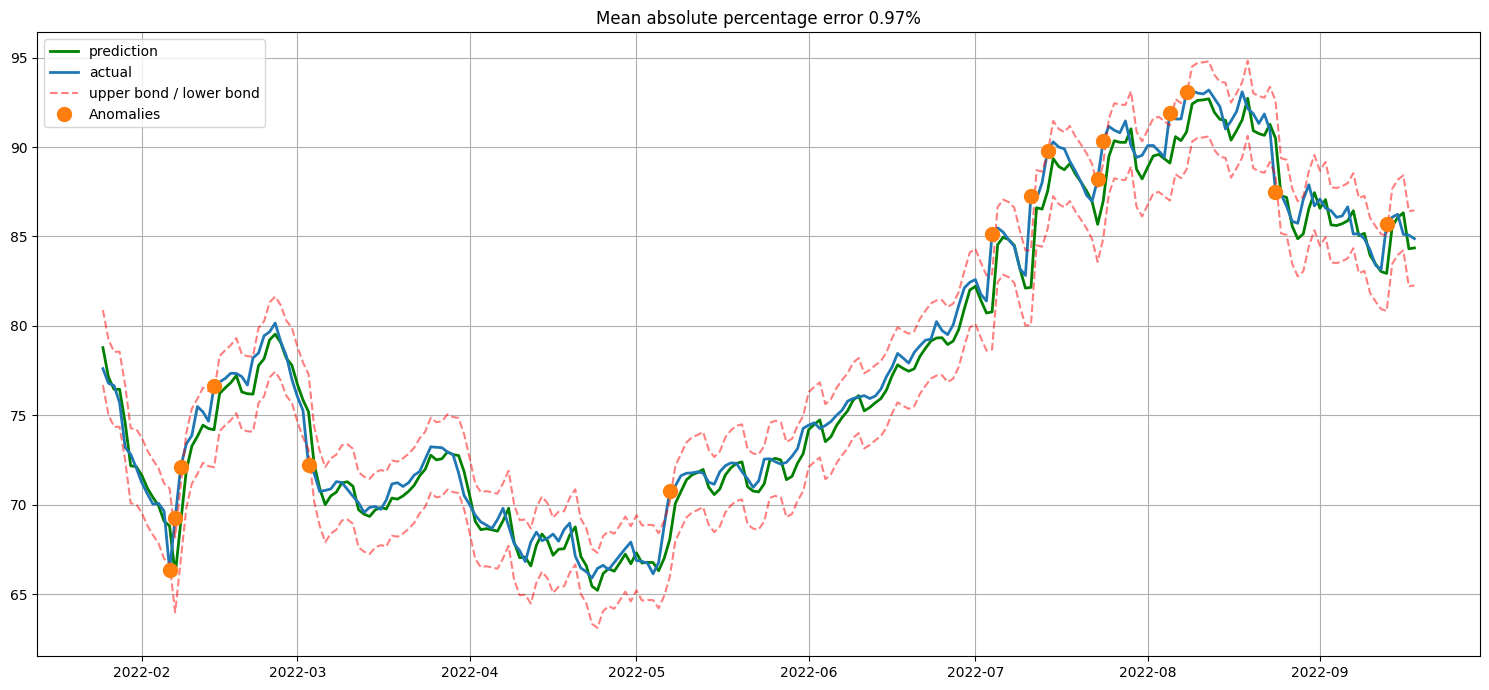

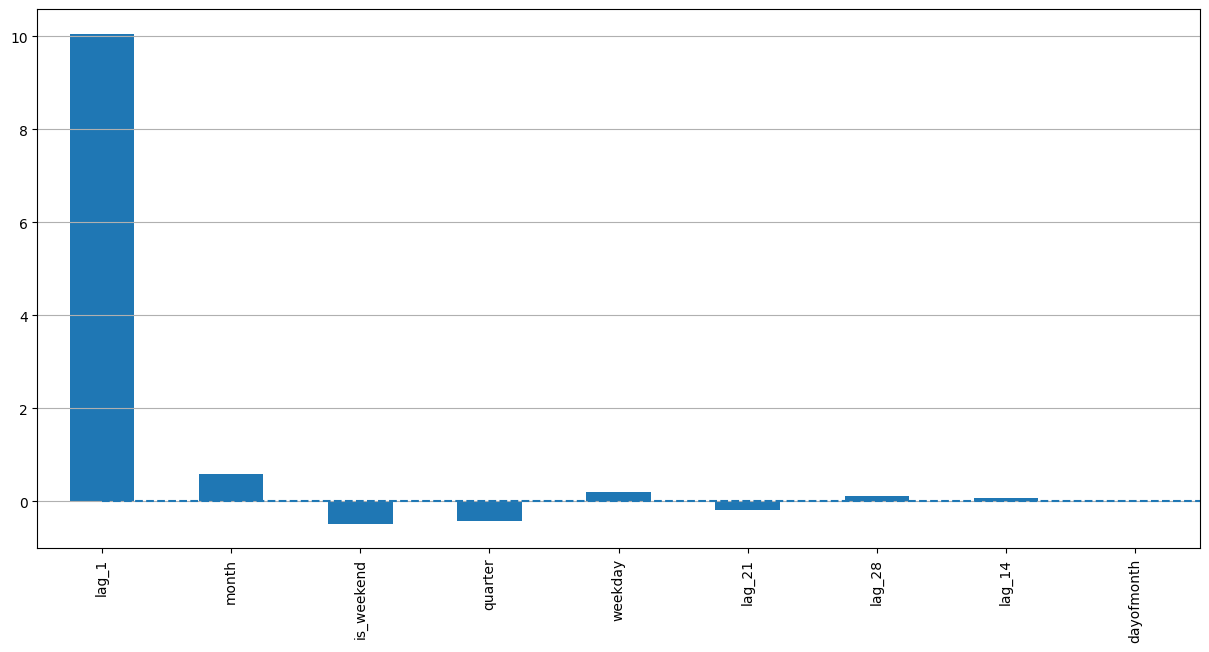

In [12]:

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)


日期全局统计特征
"mean","max", "min", "median", "sum", "skew", "std"

In [13]:

cols = ["weekday", "month", "dayofmonth", "quarter", "is_weekend"]
stats = ["mean","max", "min", "median", "sum", "skew", "std"]
makeCirclyStats(data, "y", cols, stats)
data.head()

,y,lag_1,lag_14,lag_21,lag_28,weekday,is_weekend,quarter,month,dayofmonth,...,quarter_sum,quarter_skew,quarter_std,is_weekend_mean,is_weekend_max,is_weekend_min,is_weekend_median,is_weekend_sum,is_weekend_skew,is_weekend_std
指标名称,,,,,,,,,,,,,,,,,,,,,
2015-01-02,66.7,NaN,NaN,NaN,NaN,4,0,1,1,2,...,40348.07,-0.377789,13.283873,64.267847,93.19,29.0,63.85,108355.59,-0.046244,11.109158
2015-01-04,68.9,66.7,NaN,NaN,NaN,6,1,1,1,4,...,40348.07,-0.377789,13.283873,64.644874,92.72,28.0,64.85,46027.15,-0.138350,11.039269
2015-01-05,69.3,68.9,NaN,NaN,NaN,0,0,1,1,5,...,40348.07,-0.377789,13.283873,64.267847,93.19,29.0,63.85,108355.59,-0.046244,11.109158
2015-01-06,72.3,69.3,NaN,NaN,NaN,1,0,1,1,6,...,40348.07,-0.377789,13.283873,64.267847,93.19,29.0,63.85,108355.59,-0.046244,11.109158
2015-01-07,72.7,72.3,NaN,NaN,NaN,2,0,1,1,7,...,40348.07,-0.377789,13.283873,64.267847,93.19,29.0,63.85,108355.59,-0.046244,11.109158


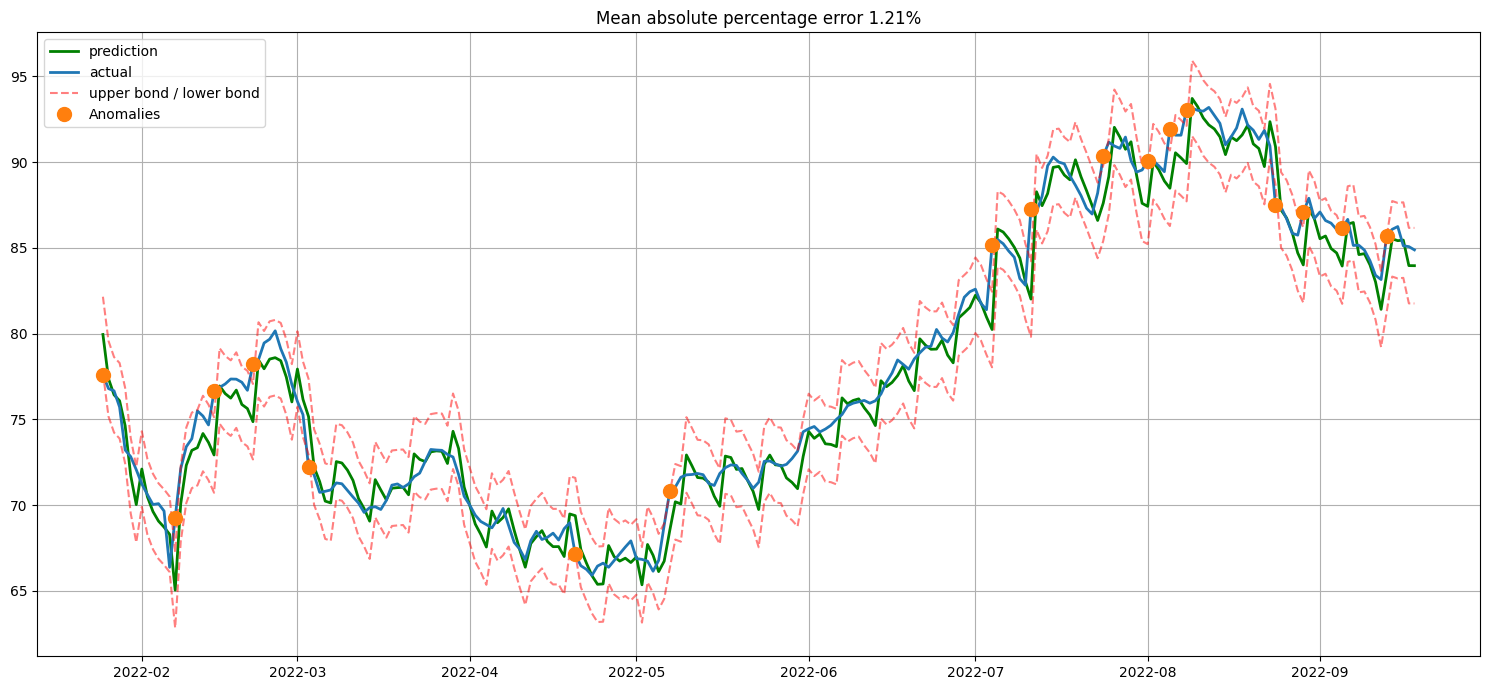

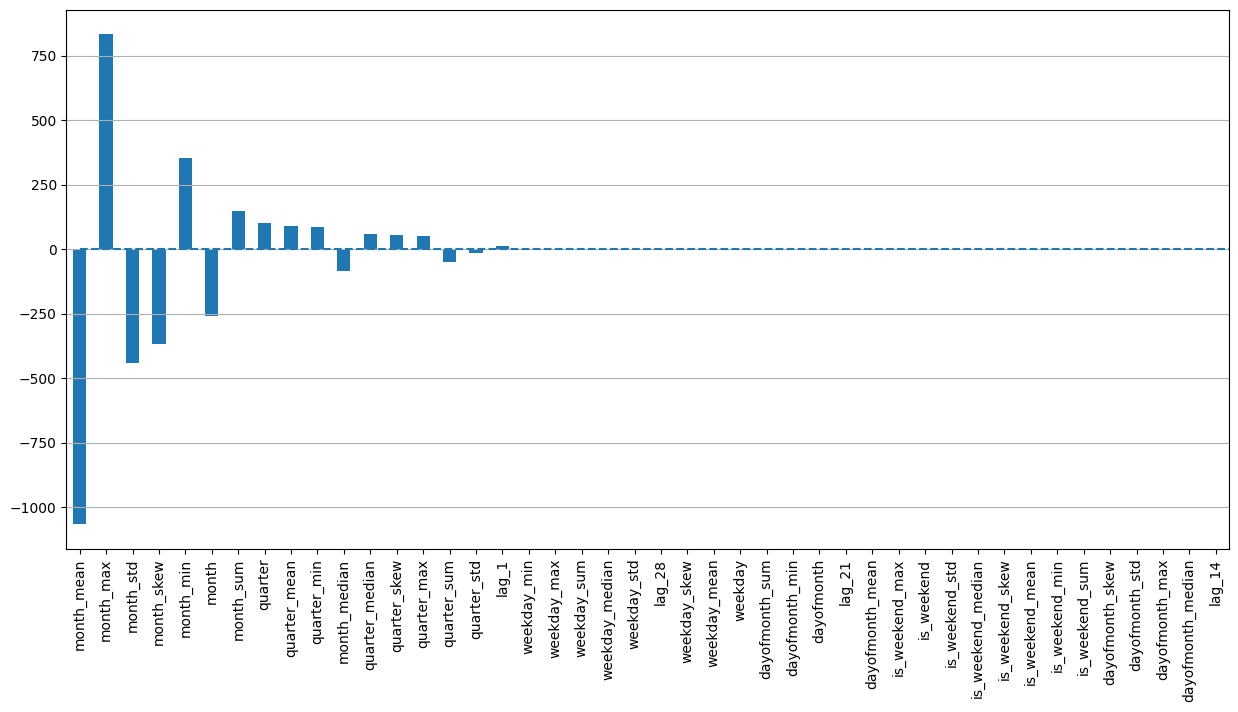

In [14]:

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)


发现有些过拟合，删掉上述特征

In [15]:

data.columns

Index(['y', 'lag_1', 'lag_14', 'lag_21', 'lag_28', 'weekday', 'is_weekend',
       'quarter', 'month', 'dayofmonth', 'weekday_mean', 'weekday_max',
       'weekday_min', 'weekday_median', 'weekday_sum', 'weekday_skew',
       'weekday_std', 'month_mean', 'month_max', 'month_min', 'month_median',
       'month_sum', 'month_skew', 'month_std', 'dayofmonth_mean',
       'dayofmonth_max', 'dayofmonth_min', 'dayofmonth_median',
       'dayofmonth_sum', 'dayofmonth_skew', 'dayofmonth_std', 'quarter_mean',
       'quarter_max', 'quarter_min', 'quarter_median', 'quarter_sum',
       'quarter_skew', 'quarter_std', 'is_weekend_mean', 'is_weekend_max',
       'is_weekend_min', 'is_weekend_median', 'is_weekend_sum',
       'is_weekend_skew', 'is_weekend_std'],
      dtype='object')

In [16]:

data = data.drop(columns=['weekday_mean', 'month_mean',
       'dayofmonth_mean', 'quarter_mean', 'is_weekend_mean', 'weekday_max',
       'weekday_min', 'weekday_median', 'weekday_sum', 'weekday_skew',
       'weekday_std', 'month_max', 'month_min', 'month_median', 'month_sum',
       'month_skew', 'month_std', 'dayofmonth_max', 'dayofmonth_min',
       'dayofmonth_median', 'dayofmonth_sum', 'dayofmonth_skew',
       'dayofmonth_std', 'quarter_max', 'quarter_min', 'quarter_median',
       'quarter_sum', 'quarter_skew', 'quarter_std', 'is_weekend_max',
       'is_weekend_min', 'is_weekend_median', 'is_weekend_sum',
       'is_weekend_skew', 'is_weekend_std'])


滚动特征
做7天、14天、28天移动均线

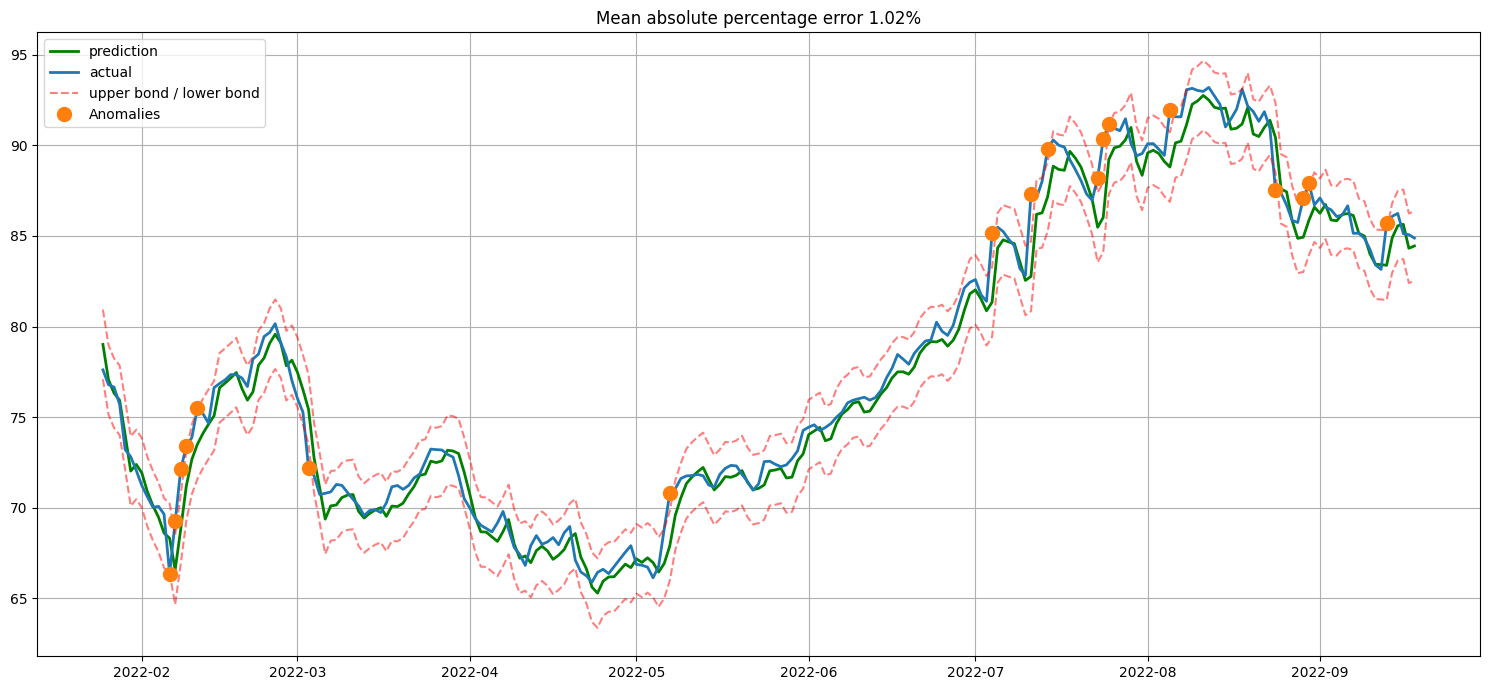

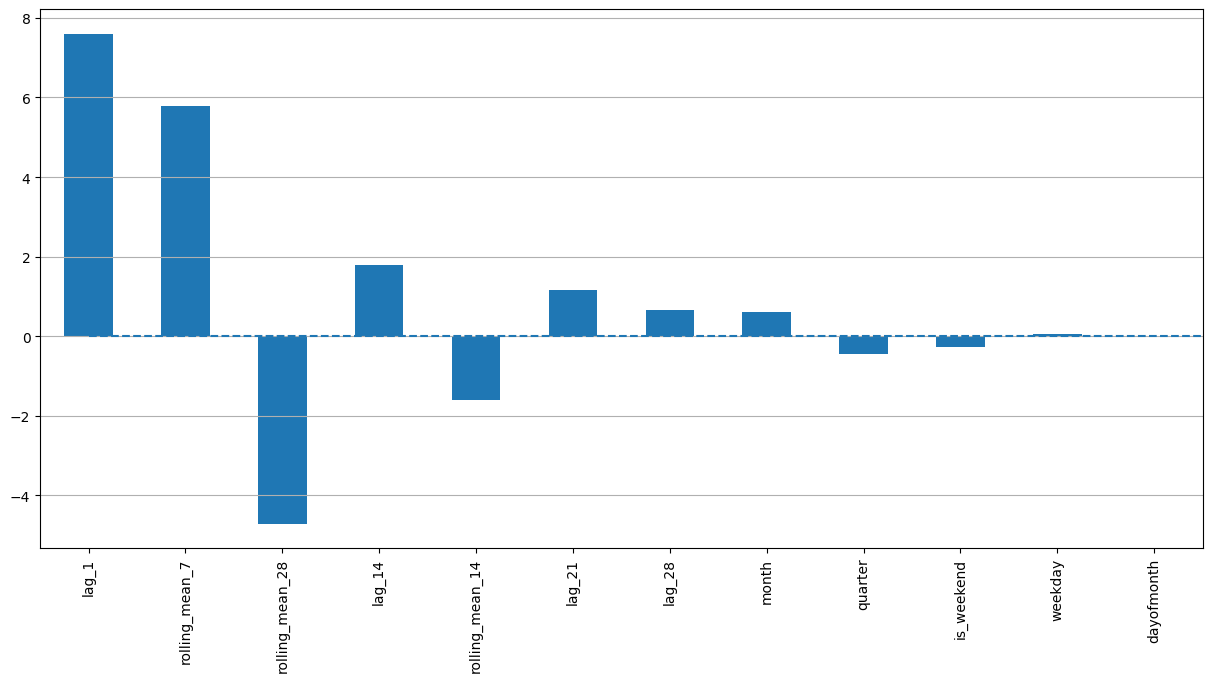

In [17]:

data['rolling_mean_7'] = data.rolling(7)['y'].mean()
data['rolling_mean_14'] = data.rolling(14)['y'].mean()
data['rolling_mean_28'] = data.rolling(28)['y'].mean()

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

每周的同一天，做滚动统计特征

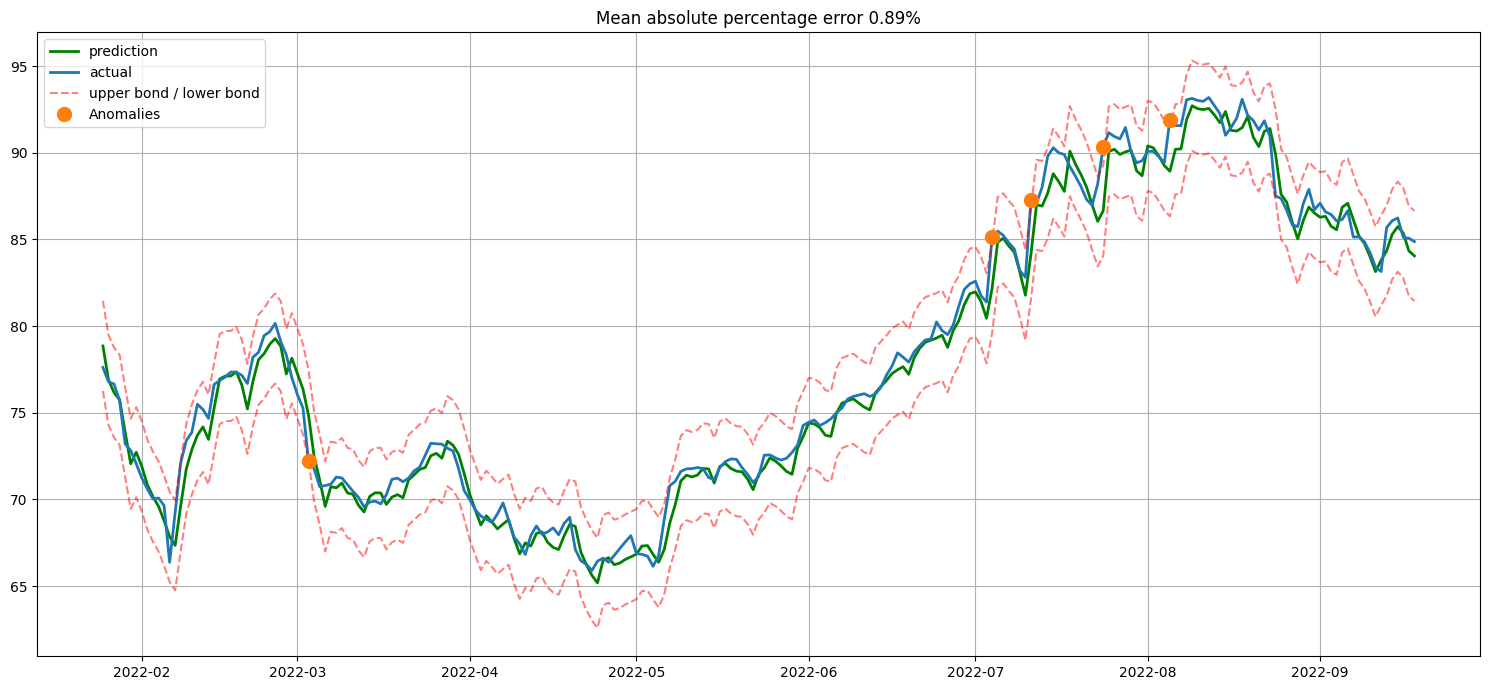

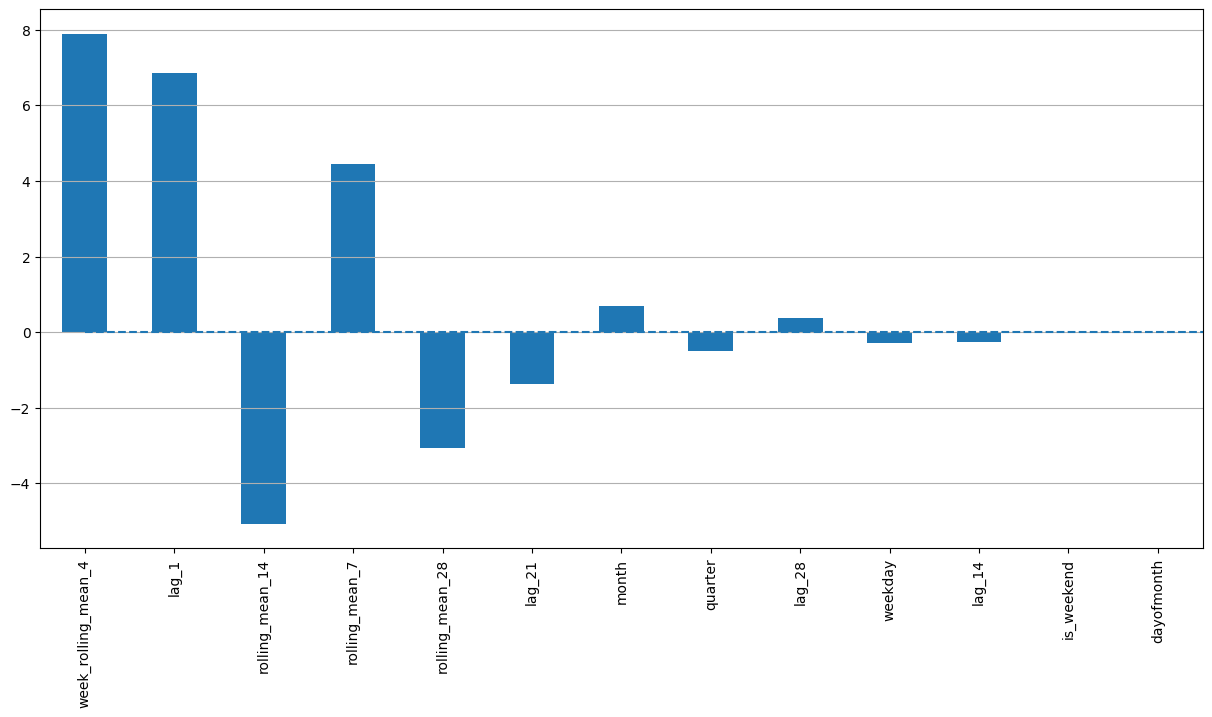

In [18]:

data['week_rolling_mean_4'] = data.groupby('weekday')["y"].transform(lambda x: x.rolling(4).mean())

# 划分训练集测试集
X_train, X_test, y_train, y_test = prepareData(data) 

# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)

# 画图
plotModelResults(lr, X_train, X_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

方法就是：每次添加新列，然后训练看效果，不好的就drop



查看当前特征变量之间的相关性

<Axes: >

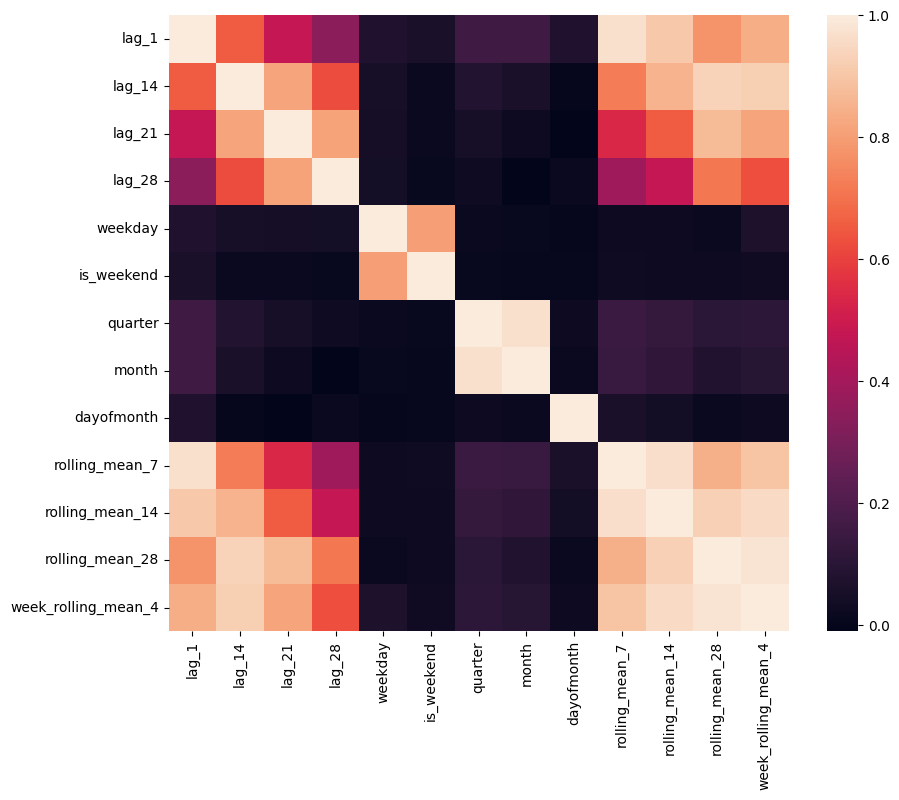

In [19]:

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr())

差不多就这些变量了，现在求他们的系数和截距项（类似于y=ax+b的a和b）

In [20]:
# 特征重要性排序
featuresRank(lr, X_train)

,coef
week_rolling_mean_4,7.891123
lag_1,6.849461
rolling_mean_14,-5.076387
rolling_mean_7,4.438939
rolling_mean_28,-3.076954
lag_21,-1.384557
month,0.691199
quarter,-0.495534
lag_28,0.362342
weekday,-0.293766


求截距

In [21]:

lr.intercept_

np.float64(62.794430379746814)

In [22]:
data.columns

Index(['y', 'lag_1', 'lag_14', 'lag_21', 'lag_28', 'weekday', 'is_weekend',
       'quarter', 'month', 'dayofmonth', 'rolling_mean_7', 'rolling_mean_14',
       'rolling_mean_28', 'week_rolling_mean_4'],
      dtype='object')

y表达式如image.png所示

总结
以上是时序特征工程的一般方法和流程：
    先增后减：逐步添加窗口平移、日期、全局、滚动特征，根据效果再删除特征
    常用代码已经封装成了函数，如果觉得好用可以直接复制粘贴
如何进一步提升效果？
    拟合残差


使用xgb拟合残差

In [23]:
# 拟合残差
y_train_e = y_train - lr.predict(X_train)
y_train_e.head()

指标名称
2015-01-31   -0.119723
2015-02-01   -0.758687
2015-02-02    1.794360
2015-02-03   -0.673864
2015-02-04   -1.626504
Name: y, dtype: float64

In [26]:
from sklearn.model_selection import cross_val_score
def objective(space):
    model = xgb.XGBRegressor(n_estimators=space['n_estimators'],
                             max_depth=int(space['max_depth']),
                             learning_rate=space['learning_rate'],
                             gamma=space['gamma'],
                             min_child_weight=space['min_child_weight'],
                             subsample=space['subsample'],
                             colsample_bytree=space['colsample_bytree']
                             )

    model.fit(X_train, y_train_e)

    # Applying k-Fold Cross Validation
    tscv = TimeSeriesSplit(n_splits=3)
    score = cross_val_score(estimator=model, X=X_train, y=y_train_e, cv=tscv)
    CrossValMean = score.mean()
    return {'loss': 1 - CrossValMean, 'status': STATUS_OK}


space = {
    'max_depth': hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators': hp.choice('n_estimators', range(20, 205, 5)),
    'gamma': hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

找best值

100%|██████████| 50/50 [01:01<00:00,  1.23s/trial, best loss: 0.9980829052307201]
{'colsample_bytree': np.float64(0.17), 'gamma': np.float64(0.49), 'learning_rate': np.float64(0.01), 'max_depth': np.int64(0), 'min_child_weight': np.float64(7.0), 'n_estimators': np.int64(32), 'subsample': np.float64(0.65)}


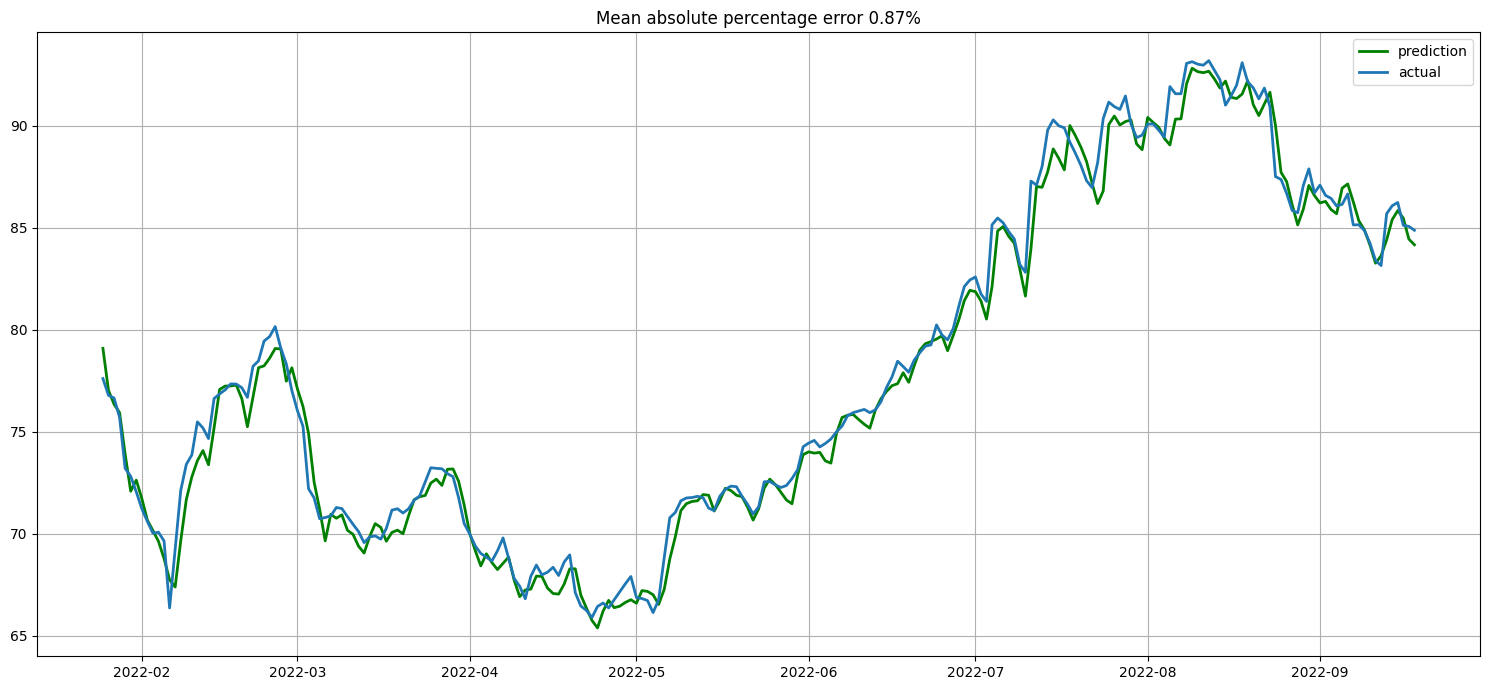

In [25]:
trials = Trials()
best = fmin(fn=objective,
             space=space,
             algo=tpe.suggest,
             max_evals=50,
             trials=trials)

print(best)

xgbReg = xgb.XGBRegressor(n_estimators=best['n_estimators'],
                           max_depth=best['max_depth'],
                       learning_rate=best['learning_rate'],
                       gamma=best['gamma'],
                       min_child_weight=best['min_child_weight'],
                       subsample=best['subsample'],
                       )
xgbReg.fit(X_train, y_train_e)


plotModelBoostingResults(lr, xgbReg, X_test, y_test)